# Epileptic Seizure Recognition


Data source: https://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition

In [92]:
import numpy as np
import pandas as pd
import time

import gc, sys
gc.enable()

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

pd.set_option('display.max_columns', 500)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [93]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [94]:
data = reduce_mem_usage(pd.read_csv('input/data.csv'))

Memory usage of dataframe is 15.79 MB
Memory usage after optimization is: 4.00 MB
Decreased by 74.7%


Attribute Information:

The original dataset from the reference consists of 5 different folders, each with 100 files, with each file representing a single subject/person. Each file is a recording of brain activity for 23.6 seconds. The corresponding time-series is sampled into 4097 data points. Each data point is the value of the EEG recording at a different point in time. So we have total 500 individuals with each has 4097 data points for 23.5 seconds.

We divided and shuffled every 4097 data points into 23 chunks, each chunk contains 178 data points for 1 second, and each data point is the value of the EEG recording at a different point in time. So now we have 23 x 500 = 11500 pieces of information(row), each information contains 178 data points for 1 second(column), the last column represents the label y {1,2,3,4,5}

The response variable is y in column 179, the Explanatory variables X1, X2, ..., X178 

In [95]:
display(data.head())
print(data.shape)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,-14,25,19,6,9,21,13,-37,-58,-33,5,47,80,101,88,73,69,41,-13,-31,-61,-80,-77,-66,-43,5,87,129,121,88,12,-76,-150,-207,-186,-165,-148,-103,-33,40,94,75,8,-81,-155,-227,-262,-233,-218,-187,-126,-65,-12,27,61,49,9,-46,-124,-210,-281,-265,-181,-89,-4,53,53,38,43,31,34,9,-7,-34,-70,-84,-101,-70,-11,42,62,66,74,64,59,56,36,-11,-30,-43,-23,8,42,77,103,135,121,79,59,43,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,309,309,303,297,295,295,293,286,279,283,301,308,285,252,215,194,169,111,-74,-388,-679,-892,-949,-972,-1001,-1006,-949,-847,-668,-432,-153,72,226,326,392,461,495,513,511,496,479,453,440,427,414,399,385,385,404,432,444,437,418,392,373,363,365,372,385,388,383,371,360,353,334,303,252,200,153,151,143,48,-206,-548,-859,-1067,-1069,-957,-780,-597,-460,-357,-276,-224,-210,-350,-930,-1413,-1716,-1360,-662,-96,243,323,241,29,-167,-228,-136,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,-15,-30,-47,-53,-65,-64,-68,-85,-98,-109,-82,-57,-38,-40,-36,-31,-13,11,19,9,-20,-48,-71,-71,-57,-32,-13,6,29,27,25,10,-7,-36,-47,-37,-36,-22,-32,-38,-55,-61,-64,-72,-67,-53,-25,-10,-4,-23,-55,-93,-102,-106,-101,-69,-45,-42,-57,-64,-77,-80,-77,-78,-56,-34,-5,10,5,-5,-44,-75,-99,-110,-104,-103,-94,-105,-108,-110,-99,-89,-82,-76,-80,-90,-106,-106,-108,-87,-60,-37,-26,-15,-6,-14,-23,-34,-41,-54,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,-69,-67,-66,-58,-54,-56,-70,-80,-82,-85,-74,-70,-71,-82,-88,-93,-97,-89,-87,-83,-70,-50,-37,-31,-32,-39,-54,-64,-68,-67,-69,-63,-60,-63,-55,-43,-37,-27,-31,-35,-47,-58,-63,-74,-73,-67,-60,-56,-49,-46,-57,-58,-62,-63,-63,-61,-56,-65,-62,-57,-61,-63,-66,-69,-86,-89,-86,-83,-87,-80,-69,-62,-57,-60,-60,-68,-58,-53,-57,-66,-66,-73,-78,-73,-84,-92,-97,-88,-81,-72,-61,-66,-72,-88,-90,-88,-77,-58,-53,-61,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,1,16,14,-14,-42,-56,-45,-45,-45,-38,-47,-45,-37,-3,23,39,27,0,-28,-44,-37,-22,5,30,31,6,-32,-27,-27,2,13,-6,-29,-41,-22,-13,-16,-31,-52,-60,-40,-16,0,14,24,36,3

(11500, 180)


Most likely, the first column contains of the patient's number and the time of recording brain activity.

Let's look at the data types

In [96]:
print('Data types: ', list(set(data.dtypes.tolist())))
print('Columns with object-type data: ', list(set(data.select_dtypes(include = ['O']).columns.tolist())))

Data types:  [dtype('O'), dtype('int8'), dtype('int16')]
Columns with object-type data:  ['Unnamed: 0']


In [97]:
data.rename(columns={'Unnamed: 0':'indx'}, inplace=True)

# Get patient_id and time of recording
data['sec'], data['patient_id'] = data['indx'].str.split('.', 1).str
print('# patients: ', data['patient_id'].nunique())
print('# length of recording brain activity (sec): ', data['sec'].nunique())
data.drop(columns=['indx'], inplace=True)
      
# Replace id with the corresponding numbers
patient_map = dict(zip(data['patient_id'].unique(), list(range(1, 501))))
data = data.replace({'patient_id': patient_map})
data['sec'] = data['sec'].str[1:]
data['sec'] = data['sec'].astype('int16')

# patients:  500
# length of recording brain activity (sec):  23


In [98]:
cols = ['patient_id', 'sec'] + list(data.columns[:-2])
data = data[cols]

In [99]:
data.head()

,patient_id,sec,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,1,21,135,190,229,223,192,125,55,-9,-33,-38,-10,35,64,113,152,164,127,50,-47,-121,-138,-125,-101,-50,11,39,24,48,64,46,13,-19,-61,-96,-130,-132,-116,-115,-71,-14,25,19,6,9,21,13,-37,-58,-33,5,47,80,101,88,73,69,41,-13,-31,-61,-80,-77,-66,-43,5,87,129,121,88,12,-76,-150,-207,-186,-165,-148,-103,-33,40,94,75,8,-81,-155,-227,-262,-233,-218,-187,-126,-65,-12,27,61,49,9,-46,-124,-210,-281,-265,-181,-89,-4,53,53,38,43,31,34,9,-7,-34,-70,-84,-101,-70,-11,42,62,66,74,64,59,56,36,-11,-30,-43,-23,8,42,77,103,135,121,79,59,43,54,90,111,107,64,32,18,-25,-69,-65,-44,-33,-57,-88,-114,-130,-114,-83,-53,-79,-72,-85,-109,-98,-72,-65,-63,-11,10,8,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,2,15,386,382,356,331,320,315,307,272,244,232,237,258,212,2,-267,-605,-850,-1001,-1109,-1090,-967,-746,-464,-152,118,318,427,473,485,447,397,339,312,314,326,335,332,324,310,312,309,309,303,297,295,295,293,286,279,283,301,308,285,252,215,194,169,111,-74,-388,-679,-892,-949,-972,-1001,-1006,-949,-847,-668,-432,-153,72,226,326,392,461,495,513,511,496,479,453,440,427,414,399,385,385,404,432,444,437,418,392,373,363,365,372,385,388,383,371,360,353,334,303,252,200,153,151,143,48,-206,-548,-859,-1067,-1069,-957,-780,-597,-460,-357,-276,-224,-210,-350,-930,-1413,-1716,-1360,-662,-96,243,323,241,29,-167,-228,-136,27,146,229,269,297,307,303,305,306,307,280,231,159,85,51,43,62,63,63,69,89,123,136,127,102,95,105,131,163,168,164,150,146,152,157,156,154,143,129,1
2,3,8,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,-99,-94,-96,-104,-103,-92,-75,-69,-69,-53,-37,-14,-10,-39,-78,-102,-98,-80,-54,-40,-35,-39,-32,-13,7,34,41,33,6,-15,-30,-47,-53,-65,-64,-68,-85,-98,-109,-82,-57,-38,-40,-36,-31,-13,11,19,9,-20,-48,-71,-71,-57,-32,-13,6,29,27,25,10,-7,-36,-47,-37,-36,-22,-32,-38,-55,-61,-64,-72,-67,-53,-25,-10,-4,-23,-55,-93,-102,-106,-101,-69,-45,-42,-57,-64,-77,-80,-77,-78,-56,-34,-5,10,5,-5,-44,-75,-99,-110,-104,-103,-94,-105,-108,-110,-99,-89,-82,-76,-80,-90,-106,-106,-108,-87,-60,-37,-26,-15,-6,-14,-23,-34,-41,-54,-82,-107,-126,-124,-108,-84,-68,-61,-56,-63,-62,-33,1,28,45,37,48,62,80,66,23,-11,-39,-44,-42,-45,-48,-42,-6,29,57,64,48,19,-12,-30,-35,-35,-36,5
3,4,16,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,-72,-68,-74,-80,-83,-73,-68,-61,-58,-59,-64,-79,-84,-97,-94,-84,-77,-75,-72,-68,-76,-76,-72,-67,-69,-69,-69,-67,-68,-69,-67,-66,-58,-54,-56,-70,-80,-82,-85,-74,-70,-71,-82,-88,-93,-97,-89,-87,-83,-70,-50,-37,-31,-32,-39,-54,-64,-68,-67,-69,-63,-60,-63,-55,-43,-37,-27,-31,-35,-47,-58,-63,-74,-73,-67,-60,-56,-49,-46,-57,-58,-62,-63,-63,-61,-56,-65,-62,-57,-61,-63,-66,-69,-86,-89,-86,-83,-87,-80,-69,-62,-57,-60,-60,-68,-58,-53,-57,-66,-66,-73,-78,-73,-84,-92,-97,-88,-81,-72,-61,-66,-72,-88,-90,-88,-77,-58,-53,-61,-69,-66,-74,-69,-61,-51,-45,-45,-49,-58,-64,-78,-80,-90,-87,-83,-78,-64,-38,-22,-29,-42,-51,-68,-71,-69,-69,-74,-74,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,5,20,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,-90,-103,-84,-43,-9,3,-21,-60,-96,-103,-75,-29,14,55,78,73,28,-13,-43,-68,-78,-75,-55,-41,-19,-20,-29,-36,-20,1,16,14,-14,-42,-56,-45,-45,-45,-38,-47,-45,-37,-3,23,39,27,0,-28,-44,-37,-22,5,30,31,6,-32,-27,-27,2,13,-6,-29,-41,-22,-13,-16,-31,-52,-60,-40,-16,0,14,24,36,39,34,17,-7,-14,-1,16,2

### Checking Missing Values

In [100]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [101]:
missing_values_table(data)

Your selected dataframe has 181 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


No missing values, that's good.

Now, let's look at the target.

y contains the category of the 178-dimensional input vector. Specifically y in {1, 2, 3, 4, 5}: 

5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open 

4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed 

3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area 

2 - They recorder the EEG from the area where the tumor was located 

1 - Recording of seizure activity 

All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure. Our motivation for creating this version of the data was to simplify access to the data via the creation of a .csv version of it. Although there are 5 classes most authors have done binary classification, namely class 1 (Epileptic seizure) against the rest.

In [102]:
data['y'].loc[data['y'] > 1] = 0
print('Target values: ', list(data['y'].unique()))

Target values:  [0, 1]


### Statistical Summary

In [103]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,11500.0,250.500000,144.343555,1.0,125.75,250.5,375.25,500.0
sec,11500.0,12.000000,6.633538,1.0,6.00,12.0,18.00,23.0
X1,11500.0,-11.581391,165.626284,-1839.0,-54.00,-8.0,34.00,1726.0
X2,11500.0,-10.911565,166.059609,-1838.0,-55.00,-8.0,35.00,1713.0
X3,11500.0,-10.187130,163.524317,-1835.0,-54.00,-7.0,36.00,1697.0
X4,11500.0,-9.143043,161.269041,-1845.0,-54.00,-8.0,36.00,1612.0
X5,11500.0,-8.009739,160.998007,-1791.0,-54.00,-8.0,35.00,1518.0
X6,11500.0,-7.003478,161.328725,-1757.0,-54.00,-8.0,36.00,1816.0
X7,11500.0,-6.502087,161.467837,-1832.0,-54.00,-8.0,35.00,2047.0
X8,11500.0,-6.687130,162.119120,-1778.0,-55.00,-8.0,36.00,2047.0


We see that the signs are about the same scale. This is logical, since our 178 features are time series with records of the EEG signal (possibly 178 different points on the human head), which means that the signals on different electrodes should not change by orders of magnitude.  
So, feature normalization is not required.

In [104]:
# Let's sort the data by patient_id and time
data = data.sort_values(['patient_id', 'sec'])
data.head()

,patient_id,sec,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
4081,1,1,51,84,105,72,-21,-101,-134,-146,-119,-77,-32,33,112,163,176,155,93,42,4,-13,-32,-24,-4,21,22,38,55,65,31,17,17,-5,-9,-15,-21,-5,9,42,27,18,39,45,48,56,72,70,43,8,-21,-37,-41,-43,-38,22,22,78,83,60,8,-28,-34,-41,-63,-70,-61,-45,-48,-77,-83,-76,-72,-65,-31,8,23,53,68,50,17,3,-30,-71,-87,-69,-28,14,72,106,100,81,21,7,-14,-45,-71,-79,-62,-21,13,68,118,107,94,93,50,-10,-30,-22,1,34,79,136,162,148,84,50,1,-32,-54,-66,-45,-24,-9,-2,-14,-52,-72,-69,-57,-60,-77,-62,-72,-74,-66,-74,-68,-20,46,51,12,-43,-90,-110,-115,-94,-92,-77,-43,-12,4,12,17,9,-12,-31,-42,-42,-38,-1,7,-17,6,87,94,32,-25,-92,-119,-117,-97,-87,-51,-6,20,22,10,-16,0
573,1,2,-46,-69,-88,-94,-96,-108,-106,-105,-100,-55,-20,-22,-26,-29,-57,-91,-75,-77,-91,-68,-39,23,97,139,131,52,-18,-81,-109,-85,-81,-97,-125,-98,-31,9,20,2,-46,-109,-138,-157,-151,-89,-41,-16,29,74,81,55,13,-42,-91,-104,-72,-54,-54,-44,-27,-24,-22,-12,-29,-51,-101,-87,-101,-115,-110,-91,4,92,135,110,63,7,-71,-137,-160,-145,-125,-82,-32,-15,32,63,50,38,20,-8,-58,-89,-77,-82,-96,-65,-33,-22,-24,-34,-13,-11,-25,-39,-72,-128,-157,-191,-209,-212,-146,-77,-27,8,26,24,11,12,-20,-30,-2,11,25,66,75,50,38,4,-49,-80,-83,-75,-32,46,94,105,100,75,22,-56,-107,-127,-123,-78,-26,3,44,33,4,18,23,22,-5,-31,-42,-46,-88,-91,-48,4,44,78,100,107,105,89,40,-25,-50,-42,-31,-29,-16,-7,-5,-19,-62,-76,0
413,1,3,-78,-93,-117,-130,-126,-66,9,77,143,133,84,36,21,-16,-43,-26,-13,49,129,194,207,197,163,69,-35,-111,-131,-140,-135,-88,-35,34,133,183,137,40,-70,-177,-258,-278,-309,-244,-135,-64,-27,25,121,181,226,233,189,106,22,-10,-25,-32,-36,-42,-59,-64,-45,-42,-38,-14,7,-10,-3,12,4,-11,-22,-26,-22,-3,21,28,53,47,59,51,87,105,76,35,-29,-67,-82,-58,-40,-32,-18,10,25,13,-34,-97,-144,-159,-123,-82,-66,-23,9,13,-24,-15,-15,-48,-83,-109,-138,-168,-171,-121,-42,47,103,85,23,-10,-25,-35,-24,-37,-68,-42,-16,-22,-55,-68,-71,-66,-33,88,193,272,313,267,170,84,0,-47,-81,-87,-34,-24,-19,3,22,25,7,2,-22,-10,-2,-6,-35,-33,0,-14,-71,-92,-112,-79,-53,-37,-25,2,-6,-20,-60,-69,-74,-65,-40,-12,0,-1,0
298,1,4,-11,-57,-84,-109,-127,-147,-167,-152,-126,-97,-50,7,54,119,172,146,55,-29,-97,-175,-207,-191,-141,-107,-74,-39,-45,-28,-21,-35,-77,-104,-126,-147,-122,-78,-1,71,114,147,144,107,47,-34,-111,-126,-97,-59,-20,12,30,43,42,-3,-46,-90,-169,-227,-251,-216,-158,-76,-11,49,66,66,85,67,9,-21,-56,-74,-78,-59,-91,-101,-75,-58,-53,-25,-13,-26,-59,-73,-96,-107,-69,9,88,166,193,171,81,17,7,16,19,38,71,65,49,42,61,82,80,67,13,-13,-35,-64,-81,-63,-36,4,78,120,150,134,108,44,10,-6,10,4,-32,-34,-22,2,27,57,43,5,-49,-85,-111,-94,-34,6,0,35,26,-12,-9,-5,-21,-61,-80,-111,-123,-95,-51,-15,10,7,-17,-40,-71,-37,-23,7,21,20,18,4,-21,-56,-46,-22,-31,-66,-99,-121,-140,-130,-73,-56,-47,-42,0
8489,1,5,-43,-64,-88,-113,-105,-104,-93,-78,-51,-14,14,36,-3,-55,-88,-102,-96,-80,-76,-58,-14,-1,24,56,70,59,55,25,-14,-42,-60,-95,-93,-72,-49,-31,-1,20,28,24,34,13,-20,-25,-7,25,40,78,108,92,61,31,12,-23,-41,-36,-42,-64,-62,-59,-73,-40,-11,-18,-20,28,70,77,79,83,84,96,132,115,45,-48,-115,-179,-200,-169,-129,-90,-21,44,85,121,121,64,1,-29,-42,-67,-86,-91,-81,-53,-6,39,68,76,119,99,38,-34,-77,-136,-122,-91,-89,-79,-59,-43,-23,-10,-25,-44,-22,-4,15,31,33,63,82,70,34,-26,-77,-87,-65,-66,-45,36,91,99,67,11,

### Class Distribution

The number of trials for the non-seizure class is: 9200
The number of trials for the epileptic seizure class is: 2300
% of epileptic seizure class:  20


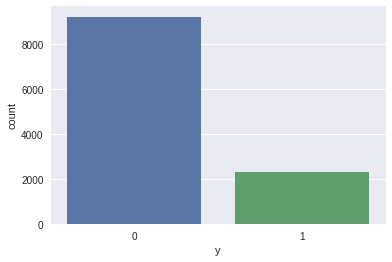

In [105]:
ax = sns.countplot(data['y'], label = "Count")
non_epileptic, epileptic = data['y'].value_counts()
print('The number of trials for the non-seizure class is:', non_epileptic)
print('The number of trials for the epileptic seizure class is:', epileptic)
print('% of epileptic seizure class: ', int(epileptic/(epileptic+non_epileptic)*100))

Classes are imbalanced. The number of patients with epilepsy in our dataset is only 20% of the total.

Let's check if the same patient has different class labels

In [106]:
assert data[['patient_id', 'y']].drop_duplicates().shape[0] == data['patient_id'].nunique()

There are no such cases, okay.

### Skew of Univariate Distributions

Skew refers to a distribution that is assumed Gaussian that is shifted or squashed in one direction or another.  
Many machine learning algorithms assume a Gaussian distribution.  
Knowing that an attribute has a skew may allow you to perform data preparation to correct the skew and later improve the accuracy of your models.

In [107]:
data.skew()

patient_id    0.000000
sec           0.000000
X1           -0.454057
X2           -0.431750
X3           -0.603564
X4           -0.549323
X5           -0.304055
X6           -0.016953
X7            0.121392
X8           -0.170715
X9           -0.455410
X10          -0.093907
X11           0.301544
X12           0.196914
X13          -0.314296
X14          -0.809309
X15          -1.039547
X16          -1.114557
X17          -0.959538
X18          -0.897592
X19          -0.684503
X20          -0.433270
X21          -0.282818
X22          -0.361187
X23          -0.357008
X24          -0.365150
X25          -0.502569
X26          -0.303322
X27          -0.266402
X28          -0.532950
                ...   
X150         -0.509814
X151         -0.523203
X152         -0.298379
X153         -0.234994
X154         -0.592457
X155         -0.749254
X156         -0.517175
X157         -0.409964
X158         -0.367868
X159         -0.340916
X160         -0.418296
X161         -0.633361
X162       

The skew results show a positive (right) or negative (left) skew. Values closer to zero show less skew.

### Correlations Between Attributes

In [108]:
data.head()

,patient_id,sec,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
4081,1,1,51,84,105,72,-21,-101,-134,-146,-119,-77,-32,33,112,163,176,155,93,42,4,-13,-32,-24,-4,21,22,38,55,65,31,17,17,-5,-9,-15,-21,-5,9,42,27,18,39,45,48,56,72,70,43,8,-21,-37,-41,-43,-38,22,22,78,83,60,8,-28,-34,-41,-63,-70,-61,-45,-48,-77,-83,-76,-72,-65,-31,8,23,53,68,50,17,3,-30,-71,-87,-69,-28,14,72,106,100,81,21,7,-14,-45,-71,-79,-62,-21,13,68,118,107,94,93,50,-10,-30,-22,1,34,79,136,162,148,84,50,1,-32,-54,-66,-45,-24,-9,-2,-14,-52,-72,-69,-57,-60,-77,-62,-72,-74,-66,-74,-68,-20,46,51,12,-43,-90,-110,-115,-94,-92,-77,-43,-12,4,12,17,9,-12,-31,-42,-42,-38,-1,7,-17,6,87,94,32,-25,-92,-119,-117,-97,-87,-51,-6,20,22,10,-16,0
573,1,2,-46,-69,-88,-94,-96,-108,-106,-105,-100,-55,-20,-22,-26,-29,-57,-91,-75,-77,-91,-68,-39,23,97,139,131,52,-18,-81,-109,-85,-81,-97,-125,-98,-31,9,20,2,-46,-109,-138,-157,-151,-89,-41,-16,29,74,81,55,13,-42,-91,-104,-72,-54,-54,-44,-27,-24,-22,-12,-29,-51,-101,-87,-101,-115,-110,-91,4,92,135,110,63,7,-71,-137,-160,-145,-125,-82,-32,-15,32,63,50,38,20,-8,-58,-89,-77,-82,-96,-65,-33,-22,-24,-34,-13,-11,-25,-39,-72,-128,-157,-191,-209,-212,-146,-77,-27,8,26,24,11,12,-20,-30,-2,11,25,66,75,50,38,4,-49,-80,-83,-75,-32,46,94,105,100,75,22,-56,-107,-127,-123,-78,-26,3,44,33,4,18,23,22,-5,-31,-42,-46,-88,-91,-48,4,44,78,100,107,105,89,40,-25,-50,-42,-31,-29,-16,-7,-5,-19,-62,-76,0
413,1,3,-78,-93,-117,-130,-126,-66,9,77,143,133,84,36,21,-16,-43,-26,-13,49,129,194,207,197,163,69,-35,-111,-131,-140,-135,-88,-35,34,133,183,137,40,-70,-177,-258,-278,-309,-244,-135,-64,-27,25,121,181,226,233,189,106,22,-10,-25,-32,-36,-42,-59,-64,-45,-42,-38,-14,7,-10,-3,12,4,-11,-22,-26,-22,-3,21,28,53,47,59,51,87,105,76,35,-29,-67,-82,-58,-40,-32,-18,10,25,13,-34,-97,-144,-159,-123,-82,-66,-23,9,13,-24,-15,-15,-48,-83,-109,-138,-168,-171,-121,-42,47,103,85,23,-10,-25,-35,-24,-37,-68,-42,-16,-22,-55,-68,-71,-66,-33,88,193,272,313,267,170,84,0,-47,-81,-87,-34,-24,-19,3,22,25,7,2,-22,-10,-2,-6,-35,-33,0,-14,-71,-92,-112,-79,-53,-37,-25,2,-6,-20,-60,-69,-74,-65,-40,-12,0,-1,0
298,1,4,-11,-57,-84,-109,-127,-147,-167,-152,-126,-97,-50,7,54,119,172,146,55,-29,-97,-175,-207,-191,-141,-107,-74,-39,-45,-28,-21,-35,-77,-104,-126,-147,-122,-78,-1,71,114,147,144,107,47,-34,-111,-126,-97,-59,-20,12,30,43,42,-3,-46,-90,-169,-227,-251,-216,-158,-76,-11,49,66,66,85,67,9,-21,-56,-74,-78,-59,-91,-101,-75,-58,-53,-25,-13,-26,-59,-73,-96,-107,-69,9,88,166,193,171,81,17,7,16,19,38,71,65,49,42,61,82,80,67,13,-13,-35,-64,-81,-63,-36,4,78,120,150,134,108,44,10,-6,10,4,-32,-34,-22,2,27,57,43,5,-49,-85,-111,-94,-34,6,0,35,26,-12,-9,-5,-21,-61,-80,-111,-123,-95,-51,-15,10,7,-17,-40,-71,-37,-23,7,21,20,18,4,-21,-56,-46,-22,-31,-66,-99,-121,-140,-130,-73,-56,-47,-42,0
8489,1,5,-43,-64,-88,-113,-105,-104,-93,-78,-51,-14,14,36,-3,-55,-88,-102,-96,-80,-76,-58,-14,-1,24,56,70,59,55,25,-14,-42,-60,-95,-93,-72,-49,-31,-1,20,28,24,34,13,-20,-25,-7,25,40,78,108,92,61,31,12,-23,-41,-36,-42,-64,-62,-59,-73,-40,-11,-18,-20,28,70,77,79,83,84,96,132,115,45,-48,-115,-179,-200,-169,-129,-90,-21,44,85,121,121,64,1,-29,-42,-67,-86,-91,-81,-53,-6,39,68,76,119,99,38,-34,-77,-136,-122,-91,-89,-79,-59,-43,-23,-10,-25,-44,-22,-4,15,31,33,63,82,70,34,-26,-77,-87,-65,-66,-45,36,91,99,67,11,

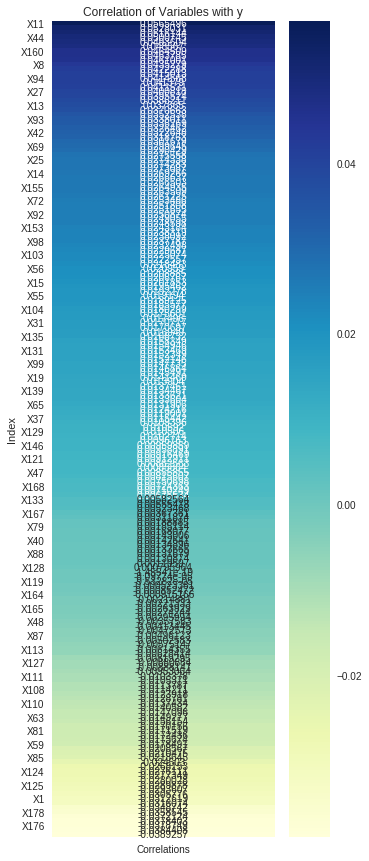

In [109]:
corr = data.corrwith(data['y'])[:-1].reset_index()
corr.columns = ['Index', 'Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)
plt.figure(figsize=(5, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='YlGnBu')
plt.title("Correlation of Variables with y");

There is no significant correlation with the target.

### Feature Importance

In [110]:
y = data['y']
X = data.drop(['y', 'patient_id', 'sec'], axis=1)

In [111]:
def plot_feature_importances(X, y=None, top_n=10, figsize=(8, 8), 
                             print_table=False, title="Feature Importances"):
    
    """
    Plot the feature importances of the forest
    """
    from sklearn.ensemble import ExtraTreesClassifier
    
    model = ExtraTreesClassifier(n_estimators=100)
    model.fit(X, y)

    feat_imp = pd.DataFrame({'importance': model.feature_importances_})    
    feat_imp['feature'] = X.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title="Feature Importances", figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))

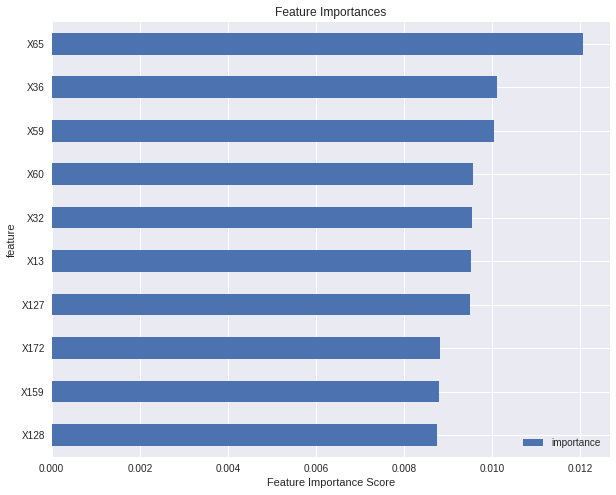

In [112]:
plot_feature_importances(X, y, figsize=(10, 8))

### Data preprocessing

Standardization is a useful technique to transform attributes with a Gaussian distribution and differing means and standard deviations to a standard Gaussian distribution with a mean of 0 and a standard deviation of 1.  
It is most suitable for techniques that assume a Gaussian distribution in the input variables and work better with rescaled data, such as linear regression, logistic regression and linear discriminate analysis.

In [113]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X_rescaled = scaler.transform(X)

### Spot-Check Classification Algorithms

Now, let's try to apply several different models as a baseline and look at their performance.  
As a performance metric we will use ROC-AUC.

In [114]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [115]:
# prepare models
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
seed=7

for name, model in models:    
    kfold = KFold(n_splits=5, random_state=seed)
    cv_results = cross_val_score(model, X_rescaled, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name) 
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.532598 (0.014187)
LDA: 0.528517 (0.013651)
KNN: 0.907192 (0.021467)
CART: 0.884412 (0.013826)
NB: 0.984157 (0.005304)
SVM: 0.994554 (0.004655)


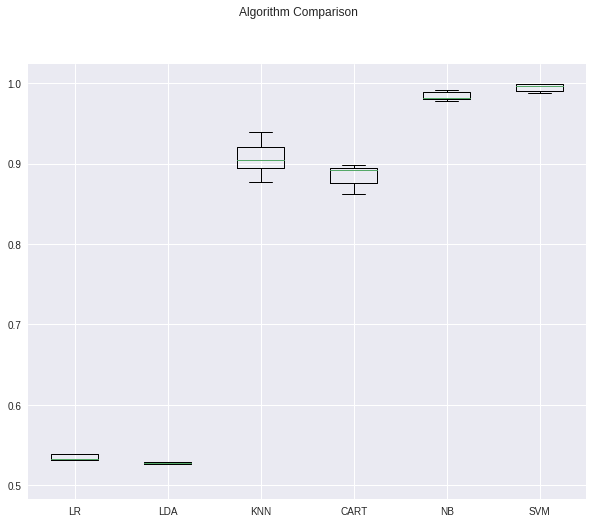

In [116]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

We can see that the SVM classifier gives a good quality of classification with parameters by default.  
Next, let's try to configure SVM hyperparameters and change the logic of cross validation.

### GreedSearch

In [88]:
#svm with grid search...very slow :)
model = SVC(class_weight = 'balanced')
param_grid = {
    'kernel':('linear', 'rbf'),
    'C':(1, 0.25, 0.5, 0.75),
    'gamma': (1, 2, 3, 'auto')
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring=scoring)
grid.fit(rescaledX, Y)

print(grid.best_score_)
print(grid.best_params_)

0.9938820964347356
{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


Our data consists of records of 500 patients. Each patient corresponds to a data group consisting of 23 observations. The i.i.d. assumption is broken because the underlying cross-validate process yield folds of dependent samples.  
Such a grouping of data is domain specific. In our example, the patient id for each sample will be its group identifier.  
In this case we would like to know if a model trained on a particular set of groups generalizes well to the unseen groups. To measure this, we need to ensure that all the samples in the validation fold come from groups that are not represented at all in the paired training fold.  
The following cross-validation splitters can be used to do that. The grouping identifier for the samples is specified via the groups parameter.

In [117]:
y = data['y'].values
X = data.drop(['y', 'patient_id', 'sec'], axis=1).values

In [118]:
results = []
groups = data['patient_id'].values
gkf = GroupKFold(n_splits=10)

# Now we split train/test folds by patients
for train_index, test_index in gkf.split(X, y, groups):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # mode class_weight='balanced' uses the values of 'y' to automatically 
    # adjust weights inversely proportional to class frequencies in the input data
    clf = SVC(kernel='rbf', gamma='auto', C=1, class_weight='balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    results.append(score)
    
print('Mean ROC_AUC: ', np.mean(results))
print('ROC_AUC std: ', np.std(results))

Mean ROC_AUC:  0.9669762571308589
ROC_AUC std:  0.012716952499782308


### Feature Selection

When using different feature extraction methods, their count can still be quite high, and not all of them can be useful in classification.
Consequently, the selection of features is performed, thereby further reducing the dimension of the feature space and increasing the efficiency of classification.

Let's try to use PCA to reduce the dimension of dataset with minimal loss of information.  
Reduction the data dimension reduces training time and prevents overfitting.

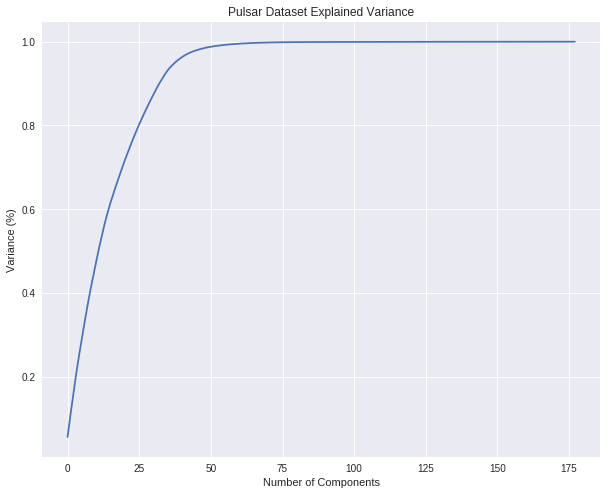

In [119]:
from sklearn.decomposition import PCA

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_rescaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

This plot tells us that selecting 50 components we can preserve something around 99% of the total variance of the data. It makes sense, we’ll not use 100% of our variance, because it denotes all components, and we want only the principal ones

In [120]:
# SVM with PCA
results = []
groups = data['patient_id'].values
gkf = GroupKFold(n_splits=10)

for train_index, test_index in gkf.split(X, y, groups):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    pca = PCA(n_components=50)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = SVC(kernel='rbf', gamma='auto', C=1, class_weight='balanced')
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    score = roc_auc_score(y_test, y_pred)
    results.append(score)
    
print('Mean ROC_AUC: ', np.mean(results))
print('ROC_AUC std: ', np.std(results))

Mean ROC_AUC:  0.9702512963555547
ROC_AUC std:  0.013922720865630945


The PCA lowered the data dimension to 50 components, while the quality of classification increased.

### Feature Extraction

Now, let's generate new features.

In [121]:
def feature_extract(data):
    
    X = data.drop(['y', 'sec'], axis=1)
    columns = X.columns[1:]  # drop 'patient_id' from agg

    # The maximum, minimum amplitude and difference btw them:
    max_val_df = X.groupby(['patient_id'])[columns].max().reset_index()
    min_val_df = X.groupby(['patient_id'])[columns].min().reset_index()
    diff = max_val_df - min_val_df
    diff['patient_id'] = max_val_df['patient_id']  # correct patient_id's
    for col in max_val_df.columns[1:]:
        max_val_df.rename(columns={col:col+'_max'}, inplace=True)
    for col in min_val_df.columns[1:]:
        min_val_df.rename(columns={col:col+'_min'}, inplace=True)
    for col in diff.columns[1:]:
        diff.rename(columns={col:col+'_diff'}, inplace=True)
        
    df = max_val_df.merge(min_val_df, on=['patient_id'])
    df = df.merge(diff, on=['patient_id'])
    
    del max_val_df, min_val_df, diff
    gc.collect()
    
    # Sum of positive signal amplitude values:
    p_sum = X.groupby(['patient_id'])[columns].agg(lambda x : x[x > 0].sum()).reset_index()
    for col in p_sum.columns[1:]:
        p_sum.rename(columns={col:col+'_p_sum'}, inplace=True)
        
    df = df.merge(p_sum, on=['patient_id'])
    del p_sum
    gc.collect()
    
    # RMS signal strength:
    v_rms = X.groupby(['patient_id'])[columns].agg(lambda x : np.sqrt((x**2).sum()/23)).reset_index()
    v_rms.fillna(0, inplace=True)
    for col in v_rms.columns[1:]:
        v_rms.rename(columns={col:col+'_rms'}, inplace=True)
        
    df = df.merge(v_rms, on=['patient_id'])
    del v_rms
    gc.collect()
            
    return df

In [122]:
new_features = feature_extract(data)

In [128]:
data_nf = data.merge(new_features, how='inner', on=['patient_id'])

y = data_nf['y']
X = data_nf.drop(['y', 'patient_id', 'sec'], axis=1)

In [124]:
display(data_nf.head())
print('Old dataframe shape: ', data.shape)
print('New dataframe shape: ', data_nf.shape)

,patient_id,sec,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,y,X1_max,X2_max,X3_max,X4_max,X5_max,X6_max,X7_max,X8_max,X9_max,X10_max,X11_max,X12_max,X13_max,X14_max,X15_max,X16_max,X17_max,X18_max,X19_max,X20_max,X21_max,X22_max,X23_max,X24_max,X25_max,X26_max,X27_max,X28_max,X29_max,X30_max,X31_max,X32_max,X33_max,X34_max,X35_max,X36_max,X37_max,X38_max,X39_max,X40_max,X41_max,X42_max,X43_max,X44_max,X45_max,X46_max,X47_max,X48_max,X49_max,X50_max,X51_max,X52_max,X53_max,X54_max,X55_max,X56_max,X57_max,X58_max,X59_max,X60_max,X61_max,X62_max,X63_max,X64_max,X65_max,X66_max,X67_max,X68_max,X69_max,...,X107_p_sum,X108_p_sum,X109_p_sum,X110_p_sum,X111_p_sum,X112_p_sum,X113_p_sum,X114_p_sum,X115_p_sum,X116_p_sum,X117_p_sum,X118_p_sum,X119_p_sum,X120_p_sum,X121_p_sum,X122_p_sum,X123_p_sum,X124_p_sum,X125_p_sum,X126_p_sum,X127_p_sum,X128_p_sum,X129_p_sum,X130_p_sum,X131_p_sum,X132_p_sum,X133_p_sum,X134_p_sum,X135_p_sum,X136_p_sum,X137_p_sum,X138_p_sum,X139_p_sum,X140_p_sum,X141_p_sum,X142_p_sum,X143_p_sum,X144_p_sum,X145_p_sum,X146_p_sum,X147_p_sum,X148_p_sum,X149_p_sum,X150_p_sum,X151_p_sum,X152_p_sum,X153_p_sum,X154_p_sum,X155_p_sum,X156_p_sum,X157_p_sum,X158_p_sum,X159_p_sum,X160_p_sum,X161_p_sum,X162_p_sum,X163_p_sum,X164_p_sum,X165_p_sum,X166_p_sum,X167_p_sum,X168_p_sum,X169_p_sum,X170_p_sum,X171_p_sum,X172_p_sum,X173_p_sum,X174_p_sum,X175_p_sum,X176_p_sum,X177_p_sum,X178_p_sum,X1_rms,X2_rms,X3_rms,X4_rms,X5_rms,X6_rms,X7_rms,X8_rms,X9_rms,X10_rms,X11_rms,X12_rms,X13_rms,X14_rms,X15_rms,X16_rms,X17_rms,X18_rms,X19_rms,X20_rms,X21_rms,X22_rms,X23_rms,X24_rms,X25_rms,X26_rms,X27_rms,X28_rms,X29_rms,X30_rms,X31_rms,X32_rms,X33_rms,X34_rms,X35_rms,X36_rms,X37_rms,X38_rms,X39_rms,X40_rms,X41_rms,X42_rms,X43_rms,X44_rms,X45_rms,X46_rms,X47_rms,X48_rms,X49_rms,X50_rms,X51_rms,X52_rms,X53_rms,X54_rms,X55_rms,X56_rms,X57_rms,X58_rms,X59_rms,X60_rms,X61_rms,X62_rms,X63_rms,X64_rms,X65_rms,X66_rms,X67_rms,X68_rms,X69_rms,X70_rms,X71_rms,X72_rms,X73_rms,X74_rms,X75_rms,X76_rms,X77_rms,X78_rms,X79_rms,X80_rms,X81_rms,X82_rms,X83_rms,X84_rms,X85_rms,X86_rms,X87_rms,X88_rms,X89_rms,X90_rms,X91_rms,X92_rms,X93_rms,X94_rms,X95_rms,X96_rms,X97_rms,X98_rms,X99_rms,X100_rms,X101_rms,X102_rms,X103_rms,X104_rms,X105_rms,X106_rms,X107_rms,X108_rms,X109_rms,X110_rms,X111_rms,X112_rms,X113_rms,X114_rms,X115_rms,X116_rms,X117_rms,X118_rms,X119_rms,X120_rms,X121_rms,X122_rms,X123_rms,X124_rms,X125_rms,X126_rms,X127_rms,X128_rms,X129_rms,X130_rms,X131_rms,X132_rms,X133_rms,X134_rms,X135_rms,X136_rms,X137_rms,X138_rms,X139_rms,X140_rms,X141_rms,X142_rms,X143_rms,X144_rms,X145_rms,X146_rms,X147_rms,X148_rms,X149_rms,X150_rms,X151_rms,X152_rms,X153_rms,X154_rms,X155_rms,X156_rms,X157_rms,X158_rms,X159_rms,X160_rms,X161_rms,X162_rms,X163_rms,X164_rms,X165_rms,X166_rms,X167_rms,X168_rms,X169_rms,X170_rms,X171_rms,X172_rms,X173_rms,X174_rms,X175_rms,X176_rms,X177_rms,X178_rms
0,1,1,51,84,105,72,-21,-101,-134,-146,-119,-77,-32,33,112,163,176,155,93,42,4,-13,-32,-24,-4,21,22,38,55,65,31,17,17,-5,-9,-15,-21,-5,9,42,27,18,39,45,48,56,72,70,43,8,-21,-37,-41,-43,-38,22,22,78,83,60,8,-28,-34,-41,-63,-70,-61,-45,-48,-77,-83,-76,-72,-65,-31,8,23,53,68,50,17,3,-30,-71,-87,-69,-28,14,72,106,100,81,21,7,-14,-45,-71,-79,-62,-21,13,68,118,107,94,93,5

Old dataframe shape:  (11500, 181)
New dataframe shape:  (11500, 1071)


Let's look at the importance of new features

In [125]:
model = ExtraTreesClassifier(n_estimators=100)
model.fit(X, y)

importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)

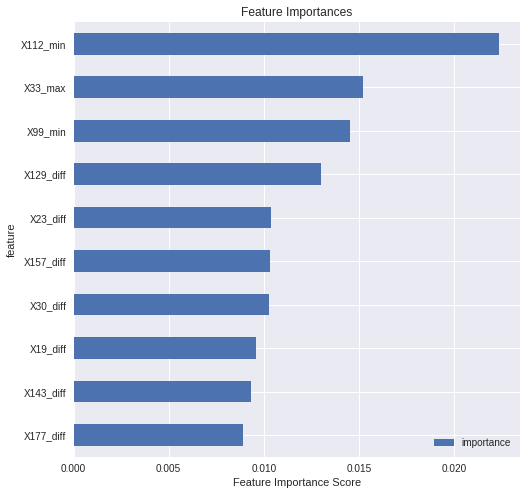

In [126]:
plot_feature_importances(X, y)

New features are quite important relative to the original features, but their total number is extremely large.  
Apply PCA to the new dataframe and see how much information added new features.

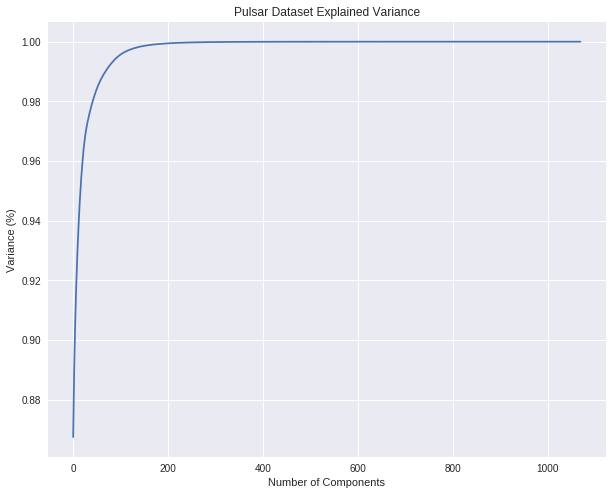

In [127]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [130]:
# SVM with PCA and new features
y = y.values
X = X.values

results = []
final_score = []
groups = data['patient_id'].values
gkf = GroupKFold(n_splits=5)
pca_components = [10, 50, 100, 200]

for n in pca_components:
    for train_index, test_index in gkf.split(X, y, groups):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        pca = PCA(n_components=n)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        clf = SVC(kernel='rbf', gamma='auto', C=1, class_weight='balanced')
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_test_pca)
        score = roc_auc_score(y_test, y_pred)
        results.append(score)
    final_score.append(np.mean(results))

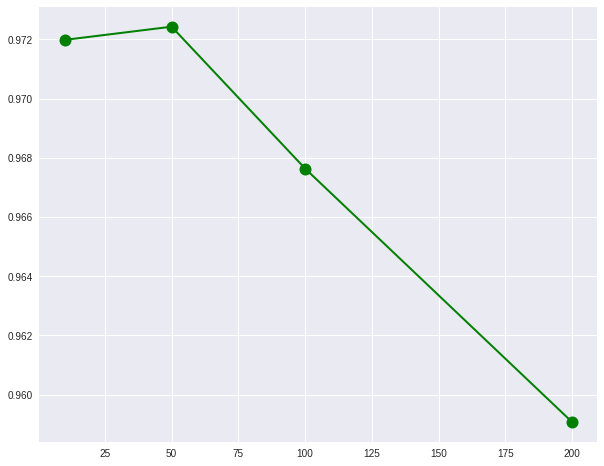

In [131]:
plt.figure(figsize=(10, 8))
plt.plot(pca_components, final_score, color='green', marker='o', 
         linestyle='-', linewidth=2, markersize=12);

And the final score with new features and PCA with 50 components:

In [132]:
# SVM with PCA and new features
results = []
groups = data['patient_id'].values
gkf = GroupKFold(n_splits=10)

for train_index, test_index in gkf.split(X, y, groups):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    pca = PCA(n_components=50)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf = SVC(kernel='rbf', gamma='auto', C=1, class_weight='balanced')
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    score = roc_auc_score(y_test, y_pred)
    results.append(score)
    
print('Mean ROC_AUC: ', np.mean(results))
print('ROC_AUC std: ', np.std(results))

Mean ROC_AUC:  0.9746832350992506
ROC_AUC std:  0.01058067540476983


Now we need to collect all this in pipeline and test it on new data.